In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
# Auto correlation functions
EPS = 1e-8

def autocorr(X, Y):
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0
    r[r < -1] = 0

    return r


def get_autocorr(feature):
    feature = torch.from_numpy(feature)
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
        autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j],
                                                  feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()

In [3]:
WWT_ATTRIBUTE_NAMES = ["domain", "access type", "agent"]
WWT_ATTRIBUTE_VALUES = {
    "domain": [
        'commons.wikimedia.org', 
        'de.wikipedia.org', 
        'en.wikipedia.org', 
        'es.wikipedia.org', 
        'fr.wikipedia.org', 
        'ja.wikipedia.org', 
        'ru.wikipedia.org', 
        'www.mediawiki.org', 
        'zh.wikipedia.org'
    ],
    "access type": [
        "all-access", "desktop", "mobile-web",
    ],
    "agent": [
        "all-agents", "spider",
    ]
}


In [15]:
# Read data

# TODO read from public location
wwt = pd.read_csv("~/data/wwt_train.csv", index_col=0)

experiments = [
    ("pytorch_fast", "synthetic_pytorch_fast.csv.gz"),
    ("pytorch_original", "synthetic_pytorch_original.csv.gz"),
    ("tf1", "synthetic_tf1.csv.gz"),
]

synthetic = {}
for name, filename in experiments:
    df = pd.read_csv(filename, index_col=0, compression="gzip")
    synthetic[name] = df
    

In [5]:
wwt_features = np.expand_dims(
    wwt.drop(columns=["domain", "access", "agent", "domain_name", "access_name", "agent_name"]).to_numpy(),
    axis=-1)

synthetic_features = {
    name: np.expand_dims(df.drop(columns=["domain","access","agent"]).to_numpy(), axis=-1)
    for name, df in synthetic.items()
}

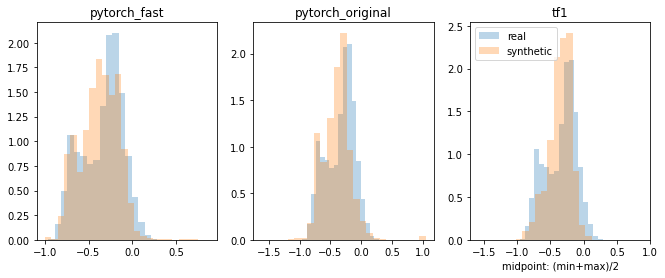

In [7]:
# Plot per sequence midpoints
# Figure 6 from paper
plt.figure(figsize=(11,4))
wwt_midpoints = get_midpoints(wwt_features)
index = 1
for name, f in synthetic_features.items():
    m = get_midpoints(f)
    
    ax = plt.subplot(1, len(synthetic_features), index)
    ax.hist(wwt_midpoints, density=True, bins=25, alpha=0.3, label="real")
    ax.hist(m, density=True, bins=25, alpha=0.3, label="synthetic")
    
    ax.set_title(name)
    index += 1

plt.xlabel("midpoint: (min+max)/2")
plt.legend()
plt.show()

(50000, 3)


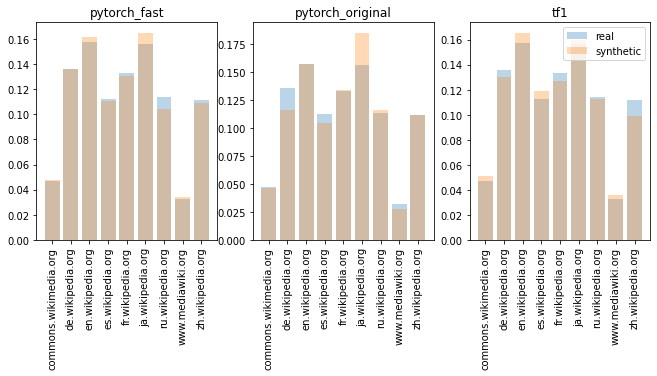

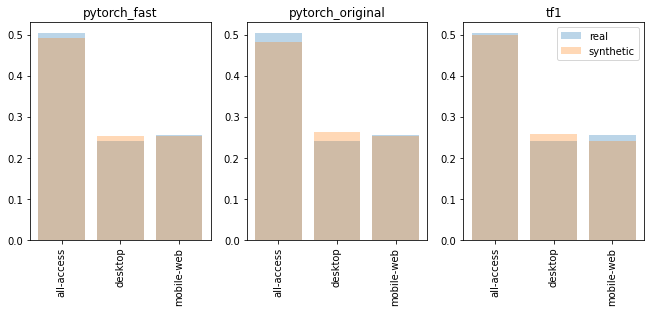

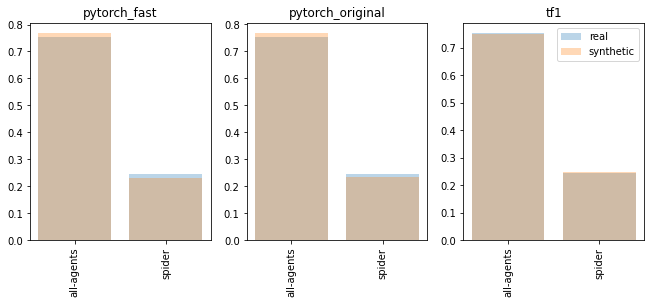

In [8]:
# Plot attribute distributions

wwt_attributes = wwt[["domain", "access", "agent"]].to_numpy().astype("int")
print(wwt_attributes.shape)


for index, attribute_name in enumerate(WWT_ATTRIBUTE_NAMES):
    
    x = WWT_ATTRIBUTE_VALUES[attribute_name]
    
    real_probs = np.bincount(wwt_attributes[:,index]) / len(wwt_attributes)
    plot_index = 1
    plt.figure(figsize=(11,4))
    for name, df in synthetic.items():
        attributes = df[["domain", "access", "agent"]].to_numpy().astype("int")

        probs = np.bincount(attributes[:,index]) / len(attributes)
        
        ax = plt.subplot(1, len(WWT_ATTRIBUTE_NAMES), plot_index)
        ax.bar(x, real_probs, alpha=0.3, label="real")
        ax.bar(x, probs, alpha=0.3, label="synthetic")
        
        ax.set_title(name)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(x, rotation="vertical")
        
        plot_index += 1
        
    plt.legend()
    plt.show()
    
    

In [9]:
# Compute autocorrelations
wwt_acf = get_autocorr(wwt_features)
synthetic_acfs = {}
for name, df in synthetic.items():
    features = np.expand_dims(df.drop(columns=["domain","access","agent"]).to_numpy(), axis=-1)
    
    acf = get_autocorr(features)
    synthetic_acfs[name] = acf


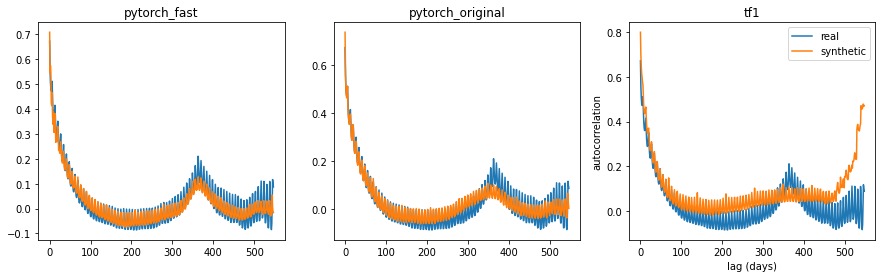

In [10]:
# Plot autocorrelations
# Figure 1 from paper


plt.figure(figsize=(15,4))
plot_index = 1
for name, acf in synthetic_acfs.items():
    
    ax = plt.subplot(1, len(synthetic), plot_index)
    
    ax.plot(wwt_acf, label="real")
    ax.plot(acf, label="synthetic")
    
    ax.set_title(name)
    
    plot_index += 1

    
plt.legend()
plt.xlabel("lag (days)")
plt.ylabel("autocorrelation")
#plt.title("Autocorrelation of daily page views for WWT data set")
plt.show()


In [11]:
sample_indices = np.random.choice(len(wwt_features),3)


In [12]:
def get_attribute_values(a):
    r = []
    for attribute_name, int_value in zip(WWT_ATTRIBUTE_NAMES, a):
        r.append(WWT_ATTRIBUTE_VALUES[attribute_name][int_value])
    return r


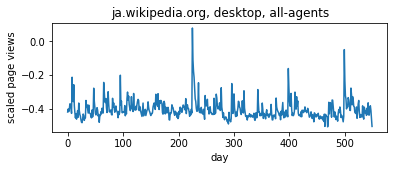

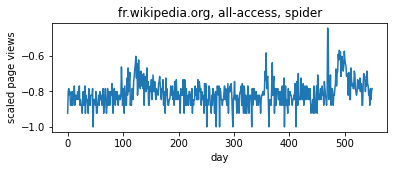

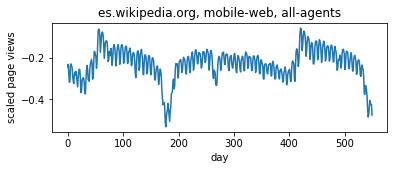

In [13]:
for index in sample_indices:
    plt.figure(figsize=(6,2))
    plt.plot(wwt_features[index,:,0])
    plt.xlabel("day")
    plt.ylabel("scaled page views")
    plt.title(", ".join(get_attribute_values(wwt_attributes[index,:])))
    plt.show()